Start with modeling:
Try neural nets and other machine learning algorithms

Input data:
We want to predict future volatility -> i.e. predict the VOLQ  
 - Past volatility, i.e. past values of the VOLQ 
 - Historical returns, i.e. log diff of the NASDAQ stock price (closing price?)
 - Add sentiment later -> start without 
 - Maybe volume of stock
 - US GDP growth
 - Consumer confidence index
 - US inflation 
 - US interest rates

1. step: download needed data, 2015-2020, merge datasets into one good pandas dataframe
2. Start with modeling, try recursive neural network? maybe first try basic ones like random forest, gradient boosting etc. 
3. Evaluate models using MSE
4. Forecasting: expanding window forecasting
5. Build classifier: 
    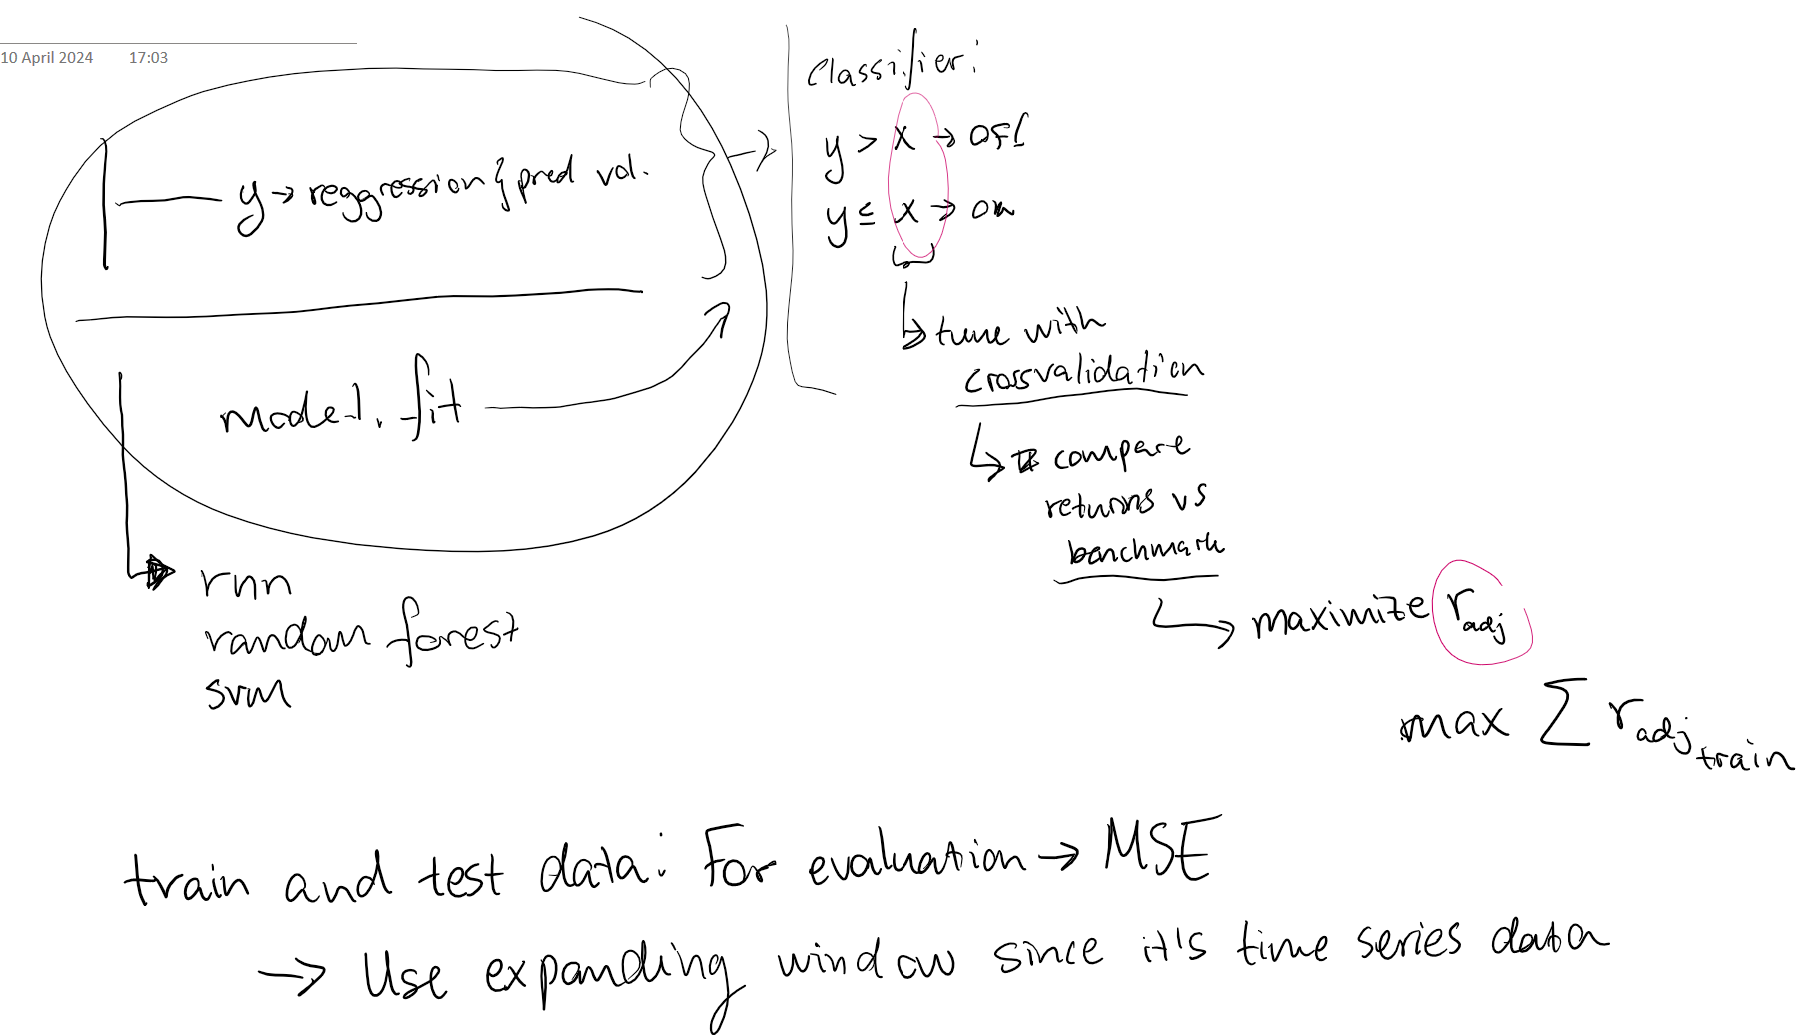
6. well see

In [20]:
#Necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### First step: Data

#### Checklist: Loading data:
 - [X] VOLQ
 - [X] Price
 - [X] Volume
 - [] US GDP growth -> only quarterly data so idk if its useful
 rest is monthly data, but we can just make it daily by having each day of the month have the same value
 - [X] Interest rates 
 - [X] Inflation
 - [X] Consumer confidence index

In [21]:
#Get volatility historical data:

url_volatility = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/volatility_data.csv'
volatility_df = pd.read_csv(url_volatility)
#make the date a datetime object:
volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])


In [22]:
volatility_df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
1253,2015-01-08,16.61,16.61,16.61,16.61,NaN,-3.43%
1254,2015-01-07,17.20,17.20,17.20,17.20,NaN,-9.71%
1255,2015-01-06,19.05,19.05,19.05,19.05,NaN,5.83%
1256,2015-01-05,18.00,18.00,18.00,18.00,NaN,8.50%
1257,2015-01-02,16.59,16.59,16.59,16.59,NaN,4.27%


In [23]:
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/Nasdaq100_price_data.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns, do this by taking the logarithm and first difference of the closing price.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-31,4294.879883,4307.009766,4233.709961,4236.279785,4236.279785,1515600000
1,2015-01-02,4258.600098,4276.709961,4206.459961,4230.240234,4230.240234,1435150000
2,2015-01-05,4206.549805,4210.959961,4151.850098,4160.959961,4160.959961,1794470000
3,2015-01-06,4174.779785,4176.259766,4090.330078,4110.830078,4110.830078,2167320000
4,2015-01-07,4139.850098,4169.970215,4126.390137,4160.000000,4160.000000,1957950000


In [24]:
price_df['Log_Returns'] = np.log(price_df['Close']).diff()*100

#drop 2014-12-31 from the data:
price_df = price_df[price_df['Date'] > '2014-12-31']
price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log_Returns
1,2015-01-02,4258.600098,4276.709961,4206.459961,4230.240234,4230.240234,1435150000,-0.142669
2,2015-01-05,4206.549805,4210.959961,4151.850098,4160.959961,4160.959961,1794470000,-1.651298
3,2015-01-06,4174.779785,4176.259766,4090.330078,4110.830078,4110.830078,2167320000,-1.212083
4,2015-01-07,4139.850098,4169.970215,4126.390137,4160.000000,4160.000000,1957950000,1.189010
5,2015-01-08,4195.490234,4247.930176,4192.629883,4240.549805,4240.549805,2105450000,1.917786


In [25]:
# CPI data:
url_cpi = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/us_cpi_dec2014to2019.csv'
cpi_df = pd.read_csv(url_cpi)

# add monthly inflation rates (log difference like the returns)
# - not sure if log-diff is the best approach for inflation but maybe makes sense for consistency at least?

cpi_df['Log_inflation'] = np.log(cpi_df['CPIAUCSL']).diff()*100

cpi_df.head()

#now, the data is monthly but we want it to be daily, 
# so we want to extend it and just keep the same values for every day of each month:

cpi_df['DATE'] = pd.to_datetime(cpi_df['DATE'])

# Filter out the first month (December 2014)
df_filtered = cpi_df[cpi_df['DATE'] > '2014-12-01']

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in df_filtered.iterrows():
    # Get the first and last day of the month
    start_date = row['DATE']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'DATE': date_range,
        'CPIAUCSL': row['CPIAUCSL'],
        'Log_inflation': row['Log_inflation']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)

cpi_daily_data = daily_data
cpi_daily_data.head()

,DATE,CPIAUCSL,Log_inflation
0,2015-01-01,234.747,-0.639069
1,2015-01-02,234.747,-0.639069
2,2015-01-03,234.747,-0.639069
3,2015-01-04,234.747,-0.639069
4,2015-01-05,234.747,-0.639069


In [26]:
# interest rates data

url_ir = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/US_interest_rates_historical.csv'
ir_df = pd.read_csv(url_ir)

#now, the data is monthly but we want it to be daily, 
# so we want to extend it and just keep the same values for every day of each month:

#make the date a datetime object:
ir_df['DATE'] = pd.to_datetime(ir_df['DATE'])

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in ir_df.iterrows():
    # Get the first and last day of the month
    start_date = row['DATE']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'DATE': date_range,
        'interest_rate': row['INTDSRUSM193N']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)
ir_daily_data = daily_data
ir_daily_data.head()

,DATE,interest_rate
0,2015-01-01,0.75
1,2015-01-02,0.75
2,2015-01-03,0.75
3,2015-01-04,0.75
4,2015-01-05,0.75


In [27]:
#get consumer confidence data:
cci_url = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/consumer_barometer_US2015to2019.csv'

cci_df = pd.read_csv(cci_url)

cci_df = pd.DataFrame({'Date': cci_df['TIME_PERIOD'],
                      'consumer_barometer': cci_df['OBS_VALUE']})

cci_df['Date'] = pd.to_datetime(cci_df['Date'])

#make it daily:

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in cci_df.iterrows():
    # Get the first and last day of the month
    start_date = row['Date']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'Date': date_range,
        'consumer_barometer': row['consumer_barometer']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)

cci_daily_data = daily_data
cci_daily_data.head()

,Date,consumer_barometer
0,2015-01-01,0.353886
1,2015-01-02,0.353886
2,2015-01-03,0.353886
3,2015-01-04,0.353886
4,2015-01-05,0.353886


In [28]:
# merge the datasets and keep only the columns of interest:

# Assuming volatility_df, price_df, cpi_daily_data, ir_daily_data, cci_daily_data are already defined

# Step 1: Standardize Date Column Names
cpi_daily_data.rename(columns={'DATE': 'Date'}, inplace=True)
ir_daily_data.rename(columns={'DATE': 'Date'}, inplace=True)

# Step 2: Merge DataFrames
# Merge volatility_df and price_df
merged_df = pd.merge(volatility_df[['Date', 'Price']], 
                     price_df[['Date', 'Log_Returns', 'Volume']], 
                     on='Date', 
                     how='inner')

# Merge with cpi_daily_data
merged_df = pd.merge(merged_df, 
                     cpi_daily_data[['Date', 'Log_inflation']], 
                     on='Date', 
                     how='inner')

# Merge with ir_daily_data
merged_df = pd.merge(merged_df, 
                     ir_daily_data[['Date', 'interest_rate']], 
                     on='Date', 
                     how='inner')

# Merge with cci_daily_data
merged_df = pd.merge(merged_df, 
                     cci_daily_data[['Date', 'consumer_barometer']], 
                     on='Date', 
                     how='inner')

# merged_df now contains all the desired columns with matching dates


In [29]:
#rename 'Price' to 'Volatility' and more relevant column names:
merged_df.rename(columns={'Price' : 'Volatility', 'Log_Returns' : 'stock_log_returns', 'Volume':'stock_volume', 'Log_inflation':'US_log_inflation', 'interest_rate':'US_interest_rate'}, inplace = True)
merged_df.head()


,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
0,2019-12-30,15.36,-0.700775,2051320000,0.290799,2.25,0.196109
1,2019-12-27,14.03,-0.083526,1833740000,0.290799,2.25,0.196109
2,2019-12-26,12.58,0.901718,1639960000,0.290799,2.25,0.196109
3,2019-12-24,12.36,0.040240,1014530000,0.290799,2.25,0.196109
4,2019-12-23,12.34,0.201670,2028670000,0.290799,2.25,0.196109


In [30]:
merged_df['Date'].min()

Timestamp('2015-01-02 00:00:00')

In [31]:
#now, the first date in the dataframe is 30-12-2019, and it goes back to 2015, but we would rather
# start from the oldest date and go to the newest so we have to reverse the order of the rows:

merged_df = merged_df.iloc[::-1]

merged_df.head()

,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
1256,2015-01-02,16.59,-0.142669,1435150000,-0.639069,0.75,0.353886
1255,2015-01-05,18.00,-1.651298,1794470000,-0.639069,0.75,0.353886
1254,2015-01-06,19.05,-1.212083,2167320000,-0.639069,0.75,0.353886
1253,2015-01-07,17.20,1.189010,1957950000,-0.639069,0.75,0.353886
1252,2015-01-08,16.61,1.917786,2105450000,-0.639069,0.75,0.353886


In [32]:
merged_df.tail()

,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
4,2019-12-23,12.34,0.201670,2028670000,0.290799,2.25,0.196109
3,2019-12-24,12.36,0.040240,1014530000,0.290799,2.25,0.196109
2,2019-12-26,12.58,0.901718,1639960000,0.290799,2.25,0.196109
1,2019-12-27,14.03,-0.083526,1833740000,0.290799,2.25,0.196109
0,2019-12-30,15.36,-0.700775,2051320000,0.290799,2.25,0.196109


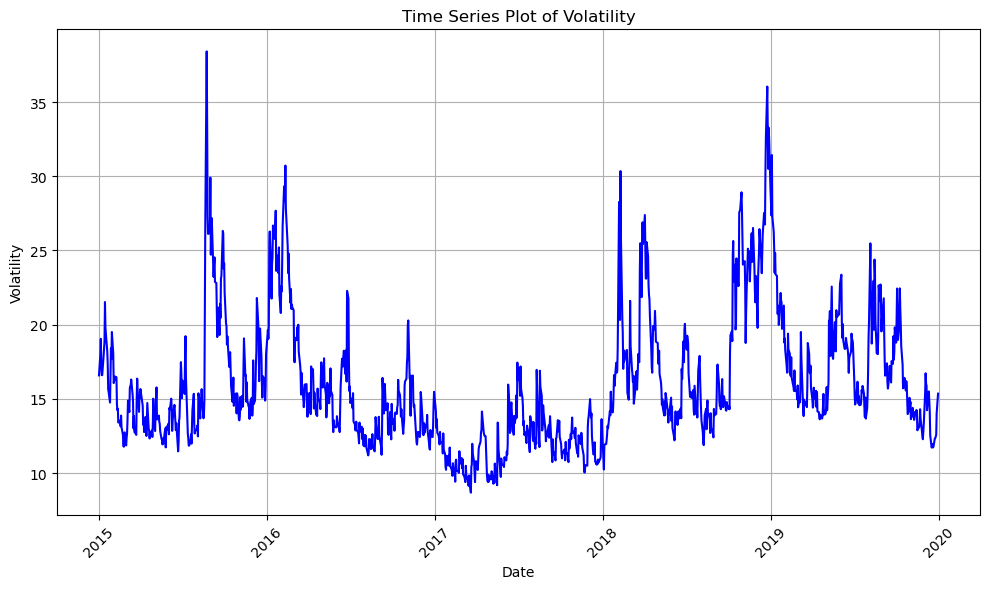

In [33]:
# Plotting the Volatility over time
plt.figure(figsize=(10, 6))  # Setting the figure size
plt.plot(merged_df['Date'], merged_df['Volatility'], linestyle='-', color='blue')  # Plotting data
plt.title('Time Series Plot of Volatility')  # Adding a title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Volatility')  # Y-axis label
plt.grid(True)  # Adding a grid for better readability
plt.xticks(rotation=45)  # Rotating X-axis labels for better readability
plt.tight_layout()  # Adjusting the layout to make room for the rotated x-axis labels

# Displaying the plot
plt.show()

C:\Users\ingam\AppData\Local\Temp\ipykernel_11024\4156287333.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr(), annot = True, cmap='coolwarm')


<Axes: >

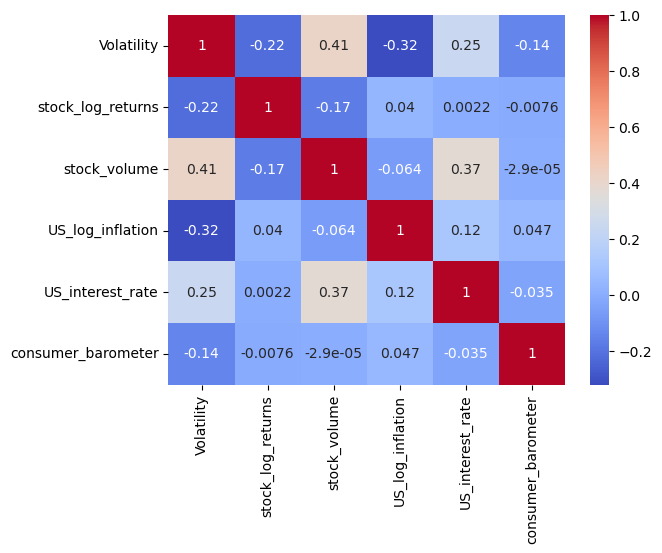

In [34]:
# look at correlation between the features:
import seaborn as sns
sns.heatmap(merged_df.corr(), annot = True, cmap='coolwarm')

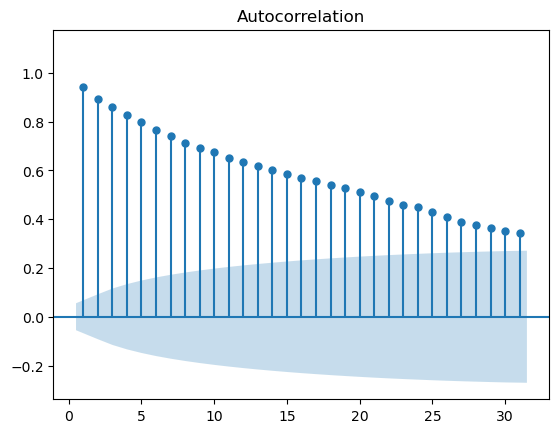

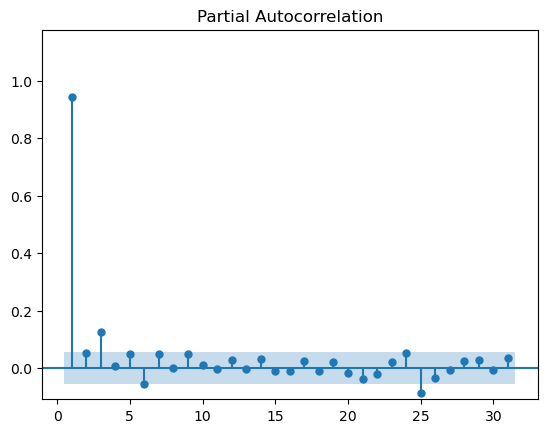

In [35]:
#look at acf and pacf of volatility to see which lags are relevant:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(merged_df['Volatility'], zero = False, auto_ylims = True)
plt.show()

plot_pacf(merged_df['Volatility'], zero = False, auto_ylims = True)
plt.show()

See that according to this we would pick a AR(1) process for the data, so to start modeling we will include 1 lag of the variance.

When modeling we want to use lagged values of the features, so first we can add columns that include the lags to the dataframe:

In [17]:
# Creating Lagged Features
#lags = 1  # Number of lags
#for column in merged_df.columns.drop('Date'):
#    for lag in range(1, lags + 1):
#        merged_df[f'{column}_lag{lag}'] = merged_df[column].shift(lag)

# Dropping rows with NaN values after shifting
#merged_df.dropna(inplace=True)

In [18]:
#merged_df.head()

,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,Volatility_lag1,stock_log_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1
1255,2015-01-05,18.00,-1.651298,1794470000,-0.639069,0.75,0.353886,16.59,-0.142669,1.435150e+09,-0.639069,0.75,0.353886
1254,2015-01-06,19.05,-1.212083,2167320000,-0.639069,0.75,0.353886,18.00,-1.651298,1.794470e+09,-0.639069,0.75,0.353886
1253,2015-01-07,17.20,1.189010,1957950000,-0.639069,0.75,0.353886,19.05,-1.212083,2.167320e+09,-0.639069,0.75,0.353886
1252,2015-01-08,16.61,1.917786,2105450000,-0.639069,0.75,0.353886,17.20,1.189010,1.957950e+09,-0.639069,0.75,0.353886
1251,2015-01-09,16.60,-0.645154,1715830000,-0.639069,0.75,0.353886,16.61,1.917786,2.105450e+09,-0.639069,0.75,0.353886


### Part 2: Modeling!!

Want to model the volatility, start maybe with models from AML assignments?:

In [22]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [30]:
X_train, X_test, y_train, y_test = train_test_split(merged_df.loc[:, merged_df.columns != 'Date'], merged_df['Volatility'], test_size=0.2, shuffle=False)

In [31]:
X_train.tail()

,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
256,32.69,-3.200174,4571670000,0.068466,3.0,0.062721
255,36.04,-2.464733,1647440000,0.068466,3.0,0.062721
254,30.50,5.978039,2572890000,0.068466,3.0,0.062721
253,33.27,0.406815,2449110000,0.068466,3.0,0.062721
252,32.54,-0.048193,2216250000,0.068466,3.0,0.062721


In [32]:
X_test.head()

,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
251,29.11,0.708673,2109320000,0.068466,3.0,0.062721
250,27.36,0.486965,2261800000,-0.081531,3.0,-0.556296
249,31.43,-3.417989,2631550000,-0.081531,3.0,-0.556296
248,27.29,4.384862,2596150000,-0.081531,3.0,-0.556296
247,26.25,1.015894,2523450000,-0.081531,3.0,-0.556296


See that the data is split so that 2019 is the test data and 2015-2018 is the training data (except for 31-12-2018...)

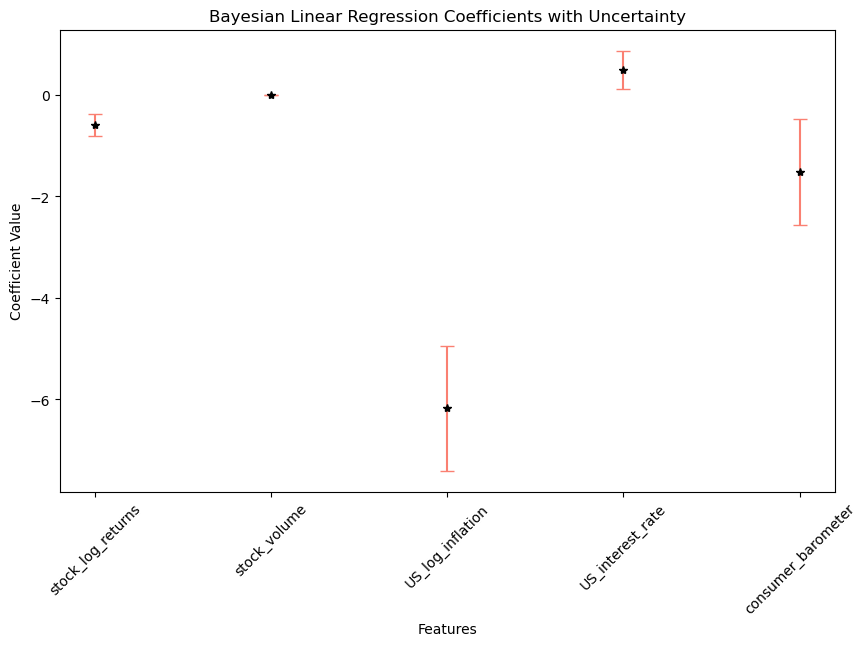

In [46]:
# Bayesian Linear Regression
bayesian_model = BayesianRidge() #stick with the default values of parameters
bayesian_model.fit(X_train.loc[:,X_train.columns != 'Volatility'], y_train)
y_pred_bayesian, y_pred_bayesian_std = bayesian_model.predict(X_test.loc[:,X_test.columns != 'Volatility'], return_std=True) #predict and return mean and std


# Extract the standard deviation of the coefficients
std_dev_coef = np.sqrt(np.diag(bayesian_model.sigma_)) #sigma contains covariacne matrix of coefficients

# Plotting the coefficient values along with standard deviation (uncertainty)
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(bayesian_model.coef_)), bayesian_model.coef_,
             yerr=1.96*std_dev_coef, # 1.96 for 95% confidence interval
             fmt='*k', # make the means stars just for fun
             ecolor='salmon', # color of error bars, salmon is prettier than red
             capsize=5)
plt.xticks(range(len(bayesian_model.coef_)), X_train.columns[X_train.columns != 'Volatility'], rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Bayesian Linear Regression Coefficients with Uncertainty')
plt.show()

In [47]:
r2_bayes = r2_score(y_test, y_pred_bayesian)
rmse_bayes = np.sqrt(mean_squared_error(y_test, y_pred_bayesian))

print(f"R2 score: {r2_bayes}, RMSE score: {rmse_bayes}")

R2 score: 0.28032486571069226, RMSE score: 2.8634672020675676


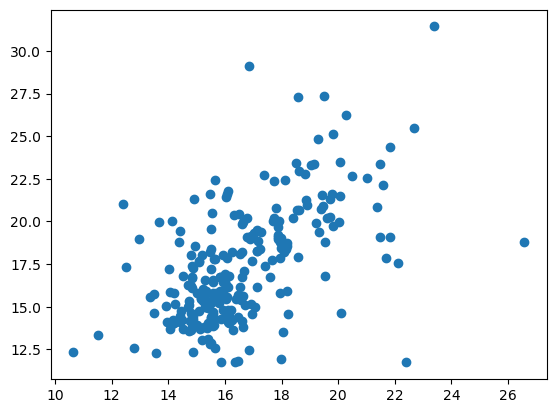

In [49]:
plt.scatter(y_pred_bayesian, y_test, )

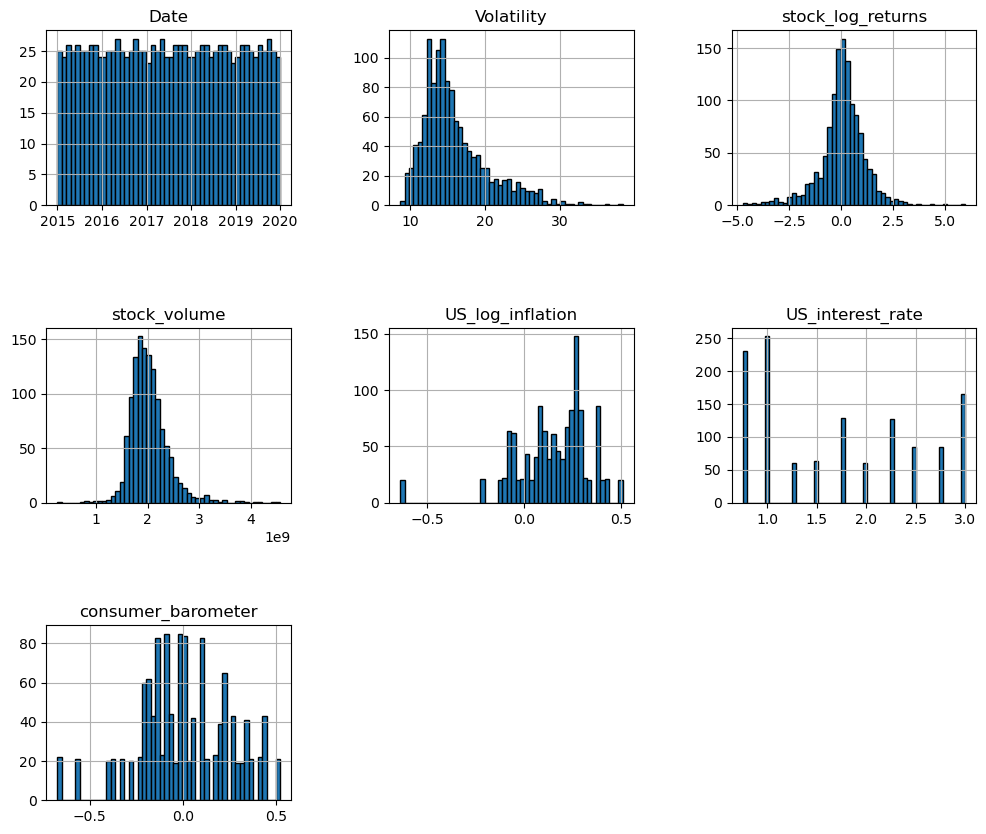

In [55]:
import seaborn as sns
merged_df.hist(figsize=(12, 10), bins=50, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [57]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 919.0 kB/s eta 0:01:49
   ---------------------------------------- 0.7/99.8 MB 5.2 MB/s eta 0:00:20
    --------------------------------------- 2.2/99.8 MB 12.5 MB/s eta 0:00:08
   - -------------------------------------- 3.8/99.8 MB 17.3 MB/s eta 0:00:06
   -- ------------------------------------- 5.5/99.8 MB 19.5 MB/s eta 0:00:05
   -- ------------------------------------- 7.1/99.8 MB 21.7 MB/s eta 0:00:05
   --- ------------------------------------ 8.8/99.8 MB 23.5 MB/s eta 0:00:04
   ---- ----------------------------------- 10.2/99.8 MB 24.2 MB/s eta 0:00:04
   ---- ----------------------

xgboost chat code model:

In [58]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming `merged_df` is your preprocessed dataset ready for modeling
X = merged_df.drop(['Date', 'Volatility'], axis=1)  # Features
y = merged_df['Volatility']  # Target variable

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predicting and evaluating
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 2.3068399129154518


In [60]:
r2 = r2_score(y_test, y_pred)
r2

0.7294878384680468

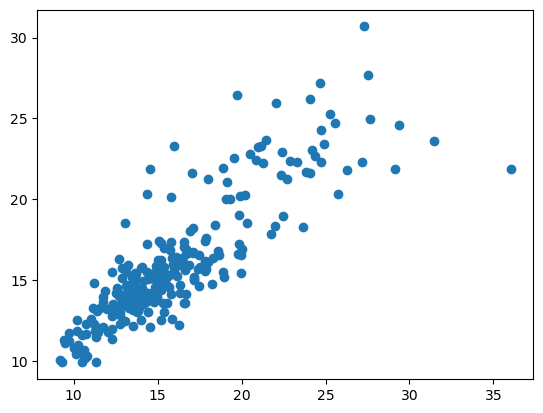

In [61]:
plt.scatter(y_test, y_pred)

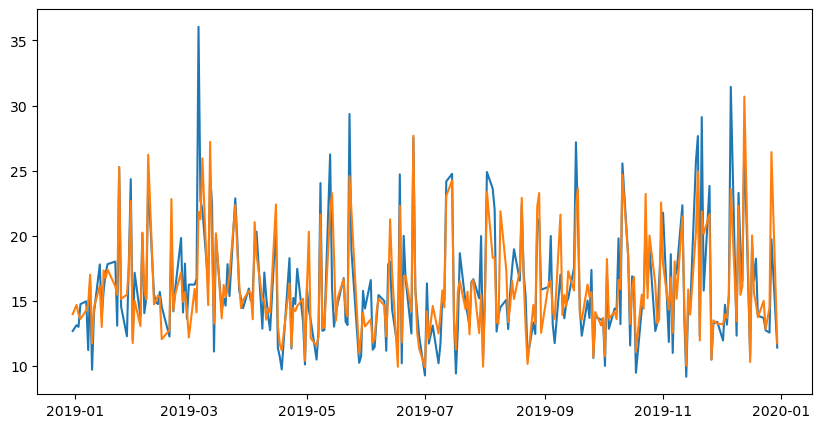

In [65]:
plt.figure(figsize=(10,5))
plt.plot(merged_df['Date'][merged_df['Date'] > '2018-12-28'], y_test)
plt.plot(merged_df['Date'][merged_df['Date'] > '2018-12-28'], y_pred)
plt.show()

In [66]:
y_train_pred = model.predict(X_train)

In [68]:
r2_score(y_train, y_train_pred)

0.9590051250626136

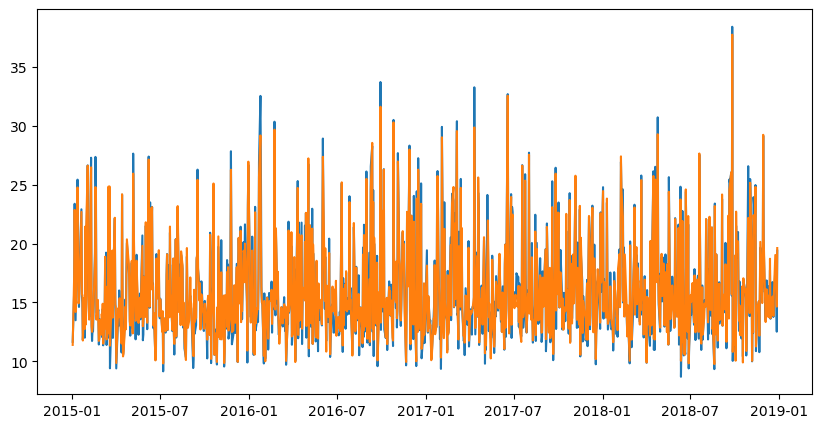

In [67]:
plt.figure(figsize=(10,5))
plt.plot(merged_df['Date'][merged_df['Date'] <= '2018-12-28'], y_train)
plt.plot(merged_df['Date'][merged_df['Date'] <= '2018-12-28'], y_train_pred)
plt.show()

#### RNN model:

using this article: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
as inspo/help

In [70]:
#preprocessing: first set date as index:
merged_df = merged_df.set_index(['Date'])

In [71]:
merged_df.head()

,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
Date,,,,,,
2015-01-02,16.59,-0.142669,1435150000,-0.639069,0.75,0.353886
2015-01-05,18.00,-1.651298,1794470000,-0.639069,0.75,0.353886
2015-01-06,19.05,-1.212083,2167320000,-0.639069,0.75,0.353886
2015-01-07,17.20,1.189010,1957950000,-0.639069,0.75,0.353886
2015-01-08,16.61,1.917786,2105450000,-0.639069,0.75,0.353886


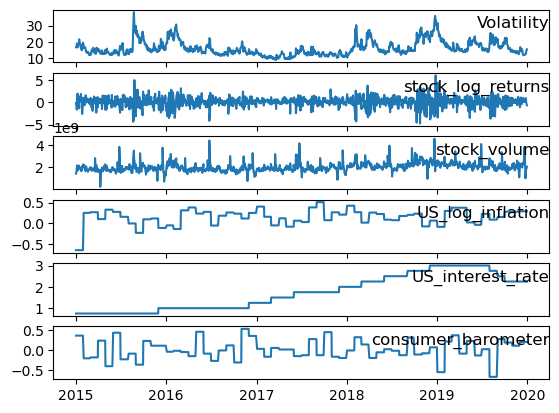

In [85]:
i = 1
# plot each column
plt.figure()
for group in merged_df.columns:
 plt.subplot(6, 1, i)
 plt.plot(merged_df[group])
 plt.title(group, y=0.5, loc='right')
 i += 1
plt.show()

In [87]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
       names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
     agg.dropna(inplace=True)
  return agg
 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(merged_df)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[1,2,3,4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)   var1(t)   var2(t)   var3(t)  var4(t)  var5(t)   var6(t)
1   0.265814  0.313257  0.288146  0.358251      0.0      0.0  0.859655
2   0.313257  0.348587  0.329127  0.444408      0.0      0.0  0.859655
3   0.348587  0.286339  0.553160  0.396028      0.0      0.0  0.859655
4   0.286339  0.266487  0.621159  0.430112      0.0      0.0  0.859655
5   0.266487  0.266151  0.382024  0.340079      0.0      0.0  0.859655


In [95]:
(len(merged_df)//5)*4

1004

In [115]:
# split into train and test sets
values = reframed.values
n_train_days = len(merged_df)//5*4 # 4/5 of the time as training data -> 80%
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1004, 1, 6) (1004,) (252, 1, 6) (252,)


In [97]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [116]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.SimpleRNN(64, return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

ValueError: Input 0 of layer "simple_rnn_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)

In [105]:
type(train_X)

numpy.ndarray

In [113]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

8/8 [==============================] - 0s 2ms/step
Test RMSE: 7.805


In [69]:
from tensorflow.keras import layers
from tensorflow.keras import models

Epoch 1/50
32/32 - 7s - loss: 2.2318 - val_loss: 0.1200 - 7s/epoch - 221ms/step
Epoch 2/50
32/32 - 0s - loss: 0.1475 - val_loss: 0.0767 - 166ms/epoch - 5ms/step
Epoch 3/50
32/32 - 0s - loss: 0.1080 - val_loss: 0.1120 - 166ms/epoch - 5ms/step
Epoch 4/50
32/32 - 0s - loss: 0.0711 - val_loss: 0.0741 - 165ms/epoch - 5ms/step
Epoch 5/50
32/32 - 0s - loss: 0.0955 - val_loss: 0.1094 - 167ms/epoch - 5ms/step
Epoch 6/50
32/32 - 0s - loss: 0.1046 - val_loss: 0.0715 - 172ms/epoch - 5ms/step
Epoch 7/50
32/32 - 0s - loss: 0.0848 - val_loss: 0.0824 - 170ms/epoch - 5ms/step
Epoch 8/50
32/32 - 0s - loss: 0.0937 - val_loss: 0.1092 - 247ms/epoch - 8ms/step
Epoch 9/50
32/32 - 0s - loss: 0.1125 - val_loss: 0.1598 - 168ms/epoch - 5ms/step
Epoch 10/50
32/32 - 0s - loss: 0.1341 - val_loss: 0.2011 - 170ms/epoch - 5ms/step
Epoch 11/50
32/32 - 0s - loss: 0.1473 - val_loss: 0.1907 - 169ms/epoch - 5ms/step
Epoch 12/50
32/32 - 0s - loss: 0.1464 - val_loss: 0.1435 - 171ms/epoch - 5ms/step
Epoch 13/50
32/32 - 0s - l

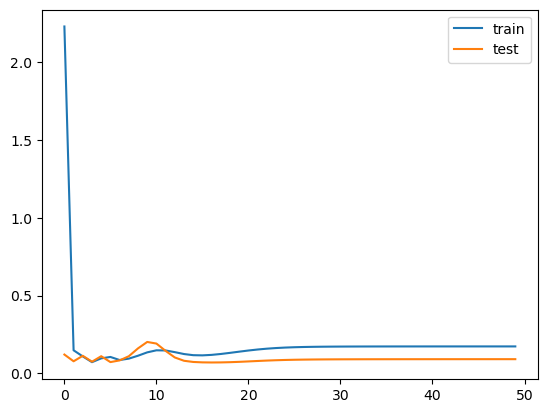

In [137]:
model_rnn = models.Sequential([
    layers.Input(shape=(train_X.shape[1], train_X.shape[2])),
    layers.Normalization(),
    #layers.SimpleRNN(64, return_sequences=True),
    #layers.SimpleRNN(16, return_sequences=False),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.SimpleRNN(64, return_sequences=True),
    layers.SimpleRNN(16, return_sequences=True),
    layers.LSTM(16, return_sequences=False),
    layers.Dense(1)#, activation="relu")
])

model_rnn.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1))
# fit network
history = model_rnn.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Try tree-based algorithms
(gradient boosting, bagging, random forest)


In [266]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

def create_lagged_features(df, columns, lags):
    for column in columns:
        for lag in range(1, lags + 1):
            df[f'{column}_lag{lag}'] = df[column].shift(lag)
    df.dropna(inplace=True)
    return df

def prepare_dataset(df, target, lags):
    df = df.sort_values('Date')
    lagged_df = create_lagged_features(df.copy(), df.columns.drop(['Date']), lags)
    X = lagged_df.drop(columns=[target, 'Date'])
    y = lagged_df[target]
    return train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

def train_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        results[name] = {'MSE': mse, 'R2': r2}
    
    return results

# Example usage
X_train, X_test, y_train, y_test = prepare_dataset(merged_df, 'Volatility', lags=1)
results = train_evaluate_models(X_train, X_test, y_train, y_test)
print(results)


{'Random Forest': {'MSE': 0.7470552181746037, 'R2': 0.9344300617093173}, 'Gradient Boosting': {'MSE': 0.7877435504164324, 'R2': 0.9308587976724146}}


<Axes: >

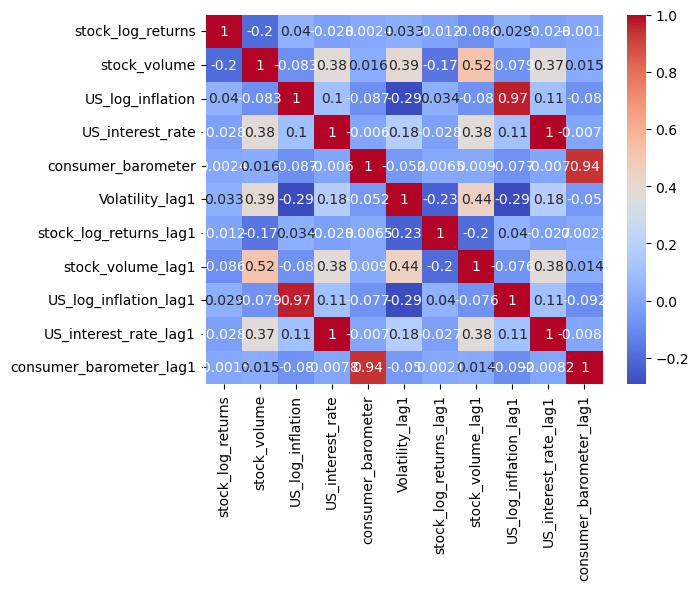

In [267]:
sns.heatmap(X_train.corr(), annot = True, cmap='coolwarm')

Next, try code from Assignment 1 AML that goes through three models and different hyperparameters using cross validation:

In [268]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV


# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]}, #number of trees in the forest and max depth
    "AdaBoost": {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.1, 1]},
    "Gradient Boosting": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [1, 3, 10]}
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=3, scoring='neg_mean_squared_error')
    param_search.fit(X_train, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance)

Model:   Random Forest
{'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]}


c:\Users\ingam\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomForestRegressor(max_depth=10, random_state=42)
Model:   AdaBoost
{'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.1, 1]}


c:\Users\ingam\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AdaBoostRegressor(learning_rate=1, random_state=42)
Model:   Gradient Boosting
{'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [1, 3, 10]}
GradientBoostingRegressor(random_state=42)
{'Random Forest': {'RMSE': 0.8616496976425458, 'R2': 0.9348351272983734, 'Best Params': {'n_estimators': 100, 'max_depth': 10}}, 'AdaBoost': {'RMSE': 0.9573513380817733, 'R2': 0.9195557941669237, 'Best Params': {'n_estimators': 50, 'learning_rate': 1}}, 'Gradient Boosting': {'RMSE': 0.8875491819704598, 'R2': 0.9308587976724146, 'Best Params': {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}}}


In [269]:
# Extract model prediction values for random forest, AdaBoost and gradient boosting:

y_pred_rf = model_predictions['Random Forest']['y_pred']
y_pred_ab = model_predictions['AdaBoost']['y_pred']
y_pred_gb = model_predictions['Gradient Boosting']['y_pred']

In [270]:
r2_rf = model_performance['Random Forest']['R2']
r2_ab = model_performance['AdaBoost']['R2']
r2_gb = model_performance['Gradient Boosting']['R2']

rmse_rf = model_performance['Random Forest']['RMSE']
rmse_ab = model_performance['AdaBoost']['RMSE']
rmse_gb = model_performance['Gradient Boosting']['RMSE']

In [271]:
compare_performance = {'Random Forest': f'R2: {r2_rf}, RMSE: {rmse_rf}',
                       'AdaBoost': f'R2: {r2_ab}, RMSE: {rmse_ab}',
                       'Gradient Boosting': f'R2: {r2_gb}, RMSE: {rmse_gb}',
}

model_names = ['Random Forest', 'AdaBoost', 'Gradient Boosting']

for model in model_names:
    print(model, ':', compare_performance[model])

Random Forest : R2: 0.9348351272983734, RMSE: 0.8616496976425458
AdaBoost : R2: 0.9195557941669237, RMSE: 0.9573513380817733
Gradient Boosting : R2: 0.9308587976724146, RMSE: 0.8875491819704598


Text(0.5, 1.0, 'Random Forest Predicted vs Actual values')

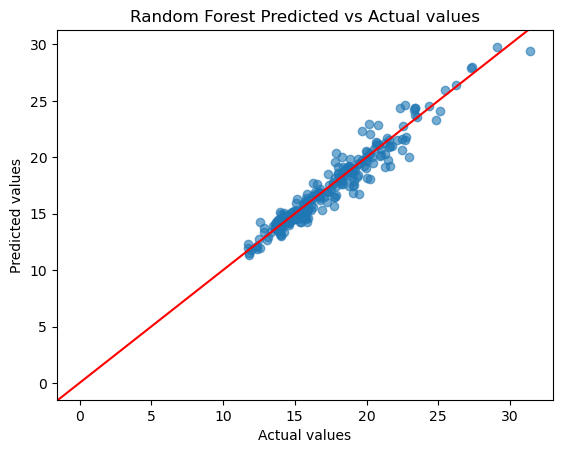

In [272]:
# Model performance : Random forest:

plt.scatter(y_test, y_pred_rf, label = 'Data points', alpha=0.6)
plt.axline((0,0), slope = 1, color = 'red')
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Random Forest Predicted vs Actual values')

Text(0.5, 1.0, 'AdaBoost Predicted vs Actual values')

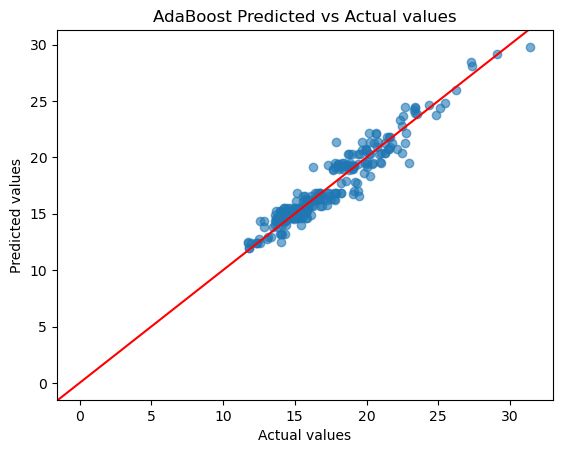

In [273]:
plt.scatter(y_test, y_pred_ab, label = 'Data points', alpha=0.6)
plt.axline((0,0), slope = 1, color = 'red')
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('AdaBoost Predicted vs Actual values')

Text(0.5, 1.0, 'Gradient Boosting Predicted vs Actual values')

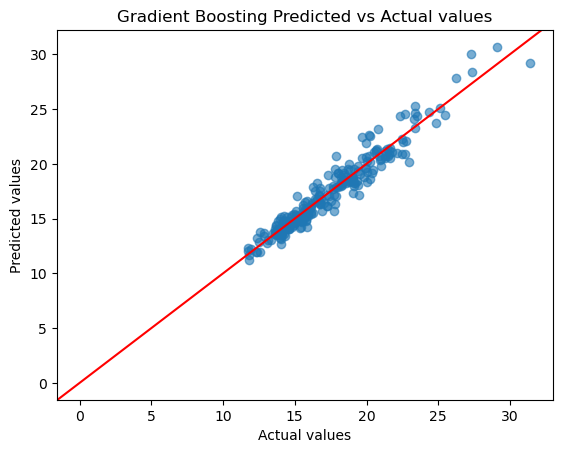

In [274]:
plt.scatter(y_test, y_pred_gb, label = 'Data points', alpha=0.6)
plt.axline((0,0), slope = 1, color = 'red')
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Gradient Boosting Predicted vs Actual values')

In [275]:
#dates for test data:
test_dates = merged_df['Date'].tail(252)

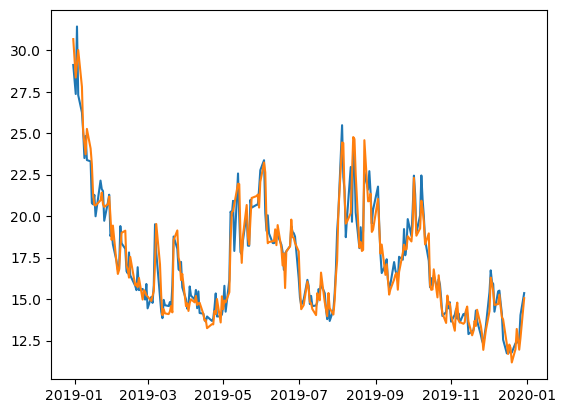

In [276]:
#plot prediction vs actual over time:
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred_gb)
plt.show()

want to instead have it more like time series, like use expanding window forecasting, how to implement?

Also: try only including the lags? not lags + todays:

In [277]:
X_train.columns

Index(['stock_log_returns', 'stock_volume', 'US_log_inflation',
       'US_interest_rate', 'consumer_barometer', 'Volatility_lag1',
       'stock_log_returns_lag1', 'stock_volume_lag1', 'US_log_inflation_lag1',
       'US_interest_rate_lag1', 'consumer_barometer_lag1'],
      dtype='object')

In [278]:
X_train_lags = X_train[['Volatility_lag1','stock_log_returns_lag1', 
                       'stock_volume_lag1', 'US_log_inflation_lag1',
                       'US_interest_rate_lag1', 'consumer_barometer_lag1']]

X_test_lags = X_test[['Volatility_lag1','stock_log_returns_lag1', 
                       'stock_volume_lag1', 'US_log_inflation_lag1',
                       'US_interest_rate_lag1', 'consumer_barometer_lag1']]

In [279]:
X_train_lags.head()

,Volatility_lag1,stock_log_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1
1255,16.59,-0.142669,1.435150e+09,-0.639069,0.75,0.353886
1254,18.00,-1.651298,1.794470e+09,-0.639069,0.75,0.353886
1253,19.05,-1.212083,2.167320e+09,-0.639069,0.75,0.353886
1252,17.20,1.189010,1.957950e+09,-0.639069,0.75,0.353886
1251,16.61,1.917786,2.105450e+09,-0.639069,0.75,0.353886


In [280]:
# same modeling but just with lags not lags + todays:

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV


# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]}, #number of trees in the forest and max depth
    "AdaBoost": {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.1, 1]},
    "Gradient Boosting": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [1, 3, 10]}
}

# Storing model performance
model_performance2 = {}
model_predictions2 = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=3, scoring='neg_mean_squared_error')
    param_search.fit(X_train_lags, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test_lags)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions2[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance2)

Model:   Random Forest
{'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]}


c:\Users\ingam\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomForestRegressor(max_depth=10, random_state=42)
Model:   AdaBoost
{'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.1, 1]}


c:\Users\ingam\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AdaBoostRegressor(learning_rate=0.1, random_state=42)
Model:   Gradient Boosting
{'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [1, 3, 10]}
GradientBoostingRegressor(n_estimators=200, random_state=42)
{'Random Forest': {'RMSE': 1.597527401334584, 'R2': 0.7759996466435833, 'Best Params': {'n_estimators': 100, 'max_depth': 10}}, 'AdaBoost': {'RMSE': 1.629110187274477, 'R2': 0.7670552160812358, 'Best Params': {'n_estimators': 50, 'learning_rate': 0.1}}, 'Gradient Boosting': {'RMSE': 1.7759175737543775, 'R2': 0.7231798618691797, 'Best Params': {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}}}


way lower, which maybe makes sense

In [281]:
# Extract model prediction values for random forest, AdaBoost and gradient boosting:

y_pred_rf = model_predictions2['Random Forest']['y_pred']
y_pred_ab = model_predictions2['AdaBoost']['y_pred']
y_pred_gb = model_predictions2['Gradient Boosting']['y_pred']

In [282]:
r2_rf = model_performance['Random Forest']['R2']
r2_ab = model_performance['AdaBoost']['R2']
r2_gb = model_performance['Gradient Boosting']['R2']

rmse_rf = model_performance['Random Forest']['RMSE']
rmse_ab = model_performance['AdaBoost']['RMSE']
rmse_gb = model_performance['Gradient Boosting']['RMSE']

compare_performance = {'Random Forest': f'R2: {r2_rf}, RMSE: {rmse_rf}',
                       'AdaBoost': f'R2: {r2_ab}, RMSE: {rmse_ab}',
                       'Gradient Boosting': f'R2: {r2_gb}, RMSE: {rmse_gb}',
}

model_names = ['Random Forest', 'AdaBoost', 'Gradient Boosting']

for model in model_names:
    print(model, ':', compare_performance[model])

Random Forest : R2: 0.9348351272983734, RMSE: 0.8616496976425458
AdaBoost : R2: 0.9195557941669237, RMSE: 0.9573513380817733
Gradient Boosting : R2: 0.9308587976724146, RMSE: 0.8875491819704598


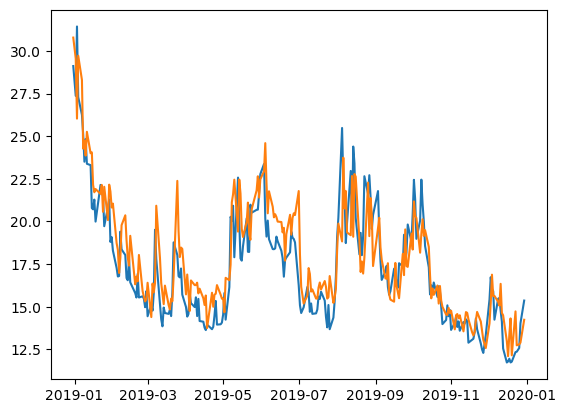

In [283]:
#plot prediction vs actual over time:
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred_gb)
plt.show()

In [284]:
X_train.shape

(1004, 11)

Now, we want to have expanding window forecasting or rolling window forecasting, start with expanding window so the following code does the same as before except now with an expanding window:

In [285]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning - use the best parameters from the code above 
parameters = {
    "Random Forest": {'n_estimators': 100, 'max_depth': 10}, #number of trees in the forest and max depth
    "AdaBoost": {'n_estimators': 50, 'learning_rate': 0.1},
    "Gradient Boosting": {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1}
}

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Implementing expanding window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start expanding window forecast
    for i in range(len(X_test_lags)):  # assuming X_test_lags is the test set features
        # Train model on available data
        X_train_expanding = pd.concat([X_train_lags, X_test_lags.iloc[:i]])
        y_train_expanding = pd.concat([y_train, y_test.iloc[:i]])
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_expanding, y_train_expanding)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(X_test_lags.iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest
Model:   AdaBoost
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.5125053957160244, 'R2': 0.7992082168350989}, 'AdaBoost': {'RMSE': 1.549810771069178, 'R2': 0.7891811591715908}, 'Gradient Boosting': {'RMSE': 1.4356896831053851, 'R2': 0.8190855607570671}}


In [286]:
# Extract model prediction values for random forest, AdaBoost and gradient boosting:

y_pred_rf = model_predictions2['Random Forest']['y_pred']
y_pred_ab = model_predictions2['AdaBoost']['y_pred']
y_pred_gb = model_predictions2['Gradient Boosting']['y_pred']

In [287]:
r2_rf = model_performance2['Random Forest']['R2']
r2_ab = model_performance2['AdaBoost']['R2']
r2_gb = model_performance2['Gradient Boosting']['R2']

rmse_rf = model_performance2['Random Forest']['RMSE']
rmse_ab = model_performance2['AdaBoost']['RMSE']
rmse_gb = model_performance2['Gradient Boosting']['RMSE']

compare_performance = {'Random Forest': f'R2: {r2_rf}, RMSE: {rmse_rf}',
                       'AdaBoost': f'R2: {r2_ab}, RMSE: {rmse_ab}',
                       'Gradient Boosting': f'R2: {r2_gb}, RMSE: {rmse_gb}',
}

model_names = ['Random Forest', 'AdaBoost', 'Gradient Boosting']

for model in model_names:
    print(model, ':', compare_performance[model])

Random Forest : R2: 0.7992082168350989, RMSE: 1.5125053957160244
AdaBoost : R2: 0.7891811591715908, RMSE: 1.549810771069178
Gradient Boosting : R2: 0.8190855607570671, RMSE: 1.4356896831053851


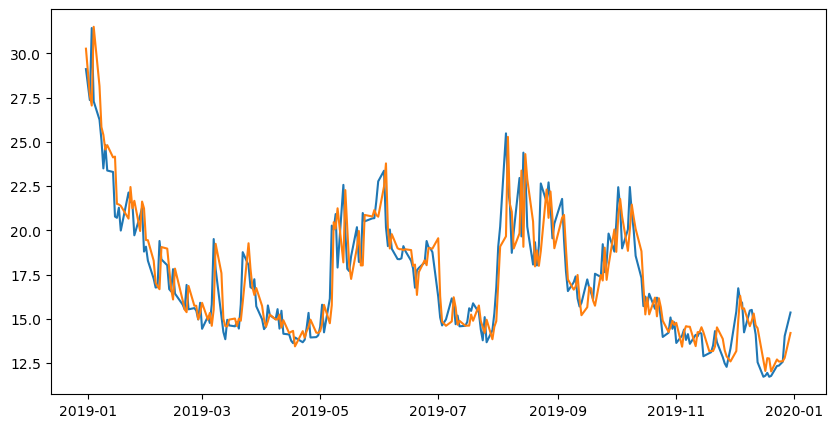

In [288]:
#plot prediction vs actual over time:
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred_gb)
plt.show()

Now, try the same except rolling window: 
- starting with window size = 180 days, not sure what the appropriate size would be, maybe 1 year? but in the data i think we only have working days so that would be 260 days (according to google - not sure if its right)
    - For 180 the results were: 
        - 'Random Forest': {'RMSE': 1.5148793787529673, 'R2': 0.798577408671461}, 
        - 'AdaBoost': {'RMSE': 1.5171776144137281, 'R2': 0.7979657854148474}, 
        - 'Gradient Boosting': {'RMSE': 1.628777690028188, 'R2': 0.7671502932537491}}

We have 1256 rows in the data, so 1/5 of that is 252 -> use a window size of 252 to have ~1 year per window

Results for 252:
 - Random Forest : R2: 0.8039945973237811, RMSE: 1.4943694672673344
 - AdaBoost : R2: 0.7784738014524102, RMSE: 1.588680305840464
 - Gradient Boosting : R2: 0.7857951455394006, RMSE: 1.5622071414267715

In [289]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 100, 'max_depth': 10}, 
    "AdaBoost": {'n_estimators': 50, 'learning_rate': 0.1},
    "Gradient Boosting": {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1}
}

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Window size
window_size = 252  # days -> 252 is the number of days in the data / 5 (so ~the number of days per year of the data)

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start rolling window forecast
    for i in range(len(X_test_lags)):  # assuming X_test_lags is the test set features
        # Define the start point for the training window
        start_point = max(0, len(X_train_lags) + i - window_size)
        end_point = len(X_train_lags) + i

        # Train model on current window data
        X_train_rolling = pd.concat([X_train_lags, X_test_lags.iloc[:i]]).iloc[start_point:end_point]
        y_train_rolling = pd.concat([y_train, y_test.iloc[:i]]).iloc[start_point:end_point]
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_rolling, y_train_rolling)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(X_test_lags.iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest
Model:   AdaBoost
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.4943694672673344, 'R2': 0.8039945973237811}, 'AdaBoost': {'RMSE': 1.588680305840464, 'R2': 0.7784738014524102}, 'Gradient Boosting': {'RMSE': 1.5622071414267715, 'R2': 0.7857951455394006}}


In [290]:
# Extract model prediction values for random forest, AdaBoost and gradient boosting:

y_pred_rf = model_predictions2['Random Forest']['y_pred']
y_pred_ab = model_predictions2['AdaBoost']['y_pred']
y_pred_gb = model_predictions2['Gradient Boosting']['y_pred']

In [291]:
r2_rf = model_performance2['Random Forest']['R2']
r2_ab = model_performance2['AdaBoost']['R2']
r2_gb = model_performance2['Gradient Boosting']['R2']

rmse_rf = model_performance2['Random Forest']['RMSE']
rmse_ab = model_performance2['AdaBoost']['RMSE']
rmse_gb = model_performance2['Gradient Boosting']['RMSE']

compare_performance = {'Random Forest': f'R2: {r2_rf}, RMSE: {rmse_rf}',
                       'AdaBoost': f'R2: {r2_ab}, RMSE: {rmse_ab}',
                       'Gradient Boosting': f'R2: {r2_gb}, RMSE: {rmse_gb}',
}

model_names = ['Random Forest', 'AdaBoost', 'Gradient Boosting']

for model in model_names:
    print(model, ':', compare_performance[model])

Random Forest : R2: 0.8039945973237811, RMSE: 1.4943694672673344
AdaBoost : R2: 0.7784738014524102, RMSE: 1.588680305840464
Gradient Boosting : R2: 0.7857951455394006, RMSE: 1.5622071414267715


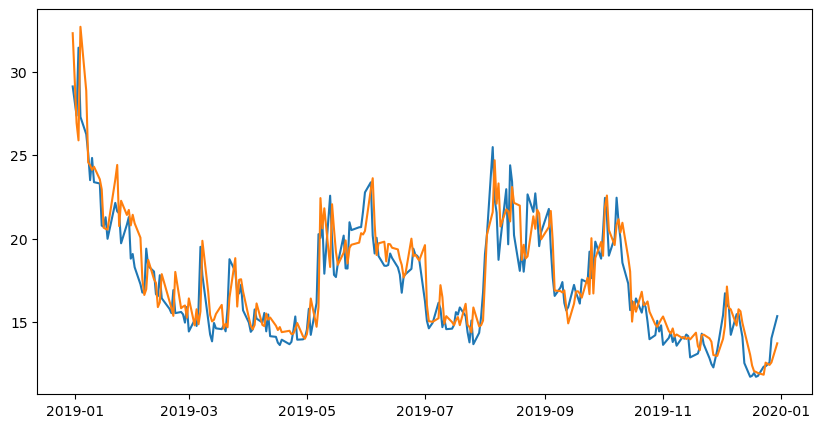

In [292]:
#plot prediction vs actual over time:
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred_rf)
plt.show()

To make it better: go through cross validation too maybe?

Next steps: 
- Try more hyperparameters!
- try including more lags
- Build neural network
- do garch and har for benchmarking (hopefully they'll perform worse...)

In [293]:
# do the same but with 2 lags included:

X_train_2lags, X_test_2lags, y_train_2lags, y_test_2lags = prepare_dataset(merged_df, 'Volatility', 2)

results = train_evaluate_models(X_train, X_test, y_train, y_test)
results2 = train_evaluate_models(X_train_2lags, X_test_2lags, y_train_2lags, y_test_2lags)

print(results)
print(results2)

{'Random Forest': {'MSE': 0.7470552181746037, 'R2': 0.9344300617093173}, 'Gradient Boosting': {'MSE': 0.7877435504164324, 'R2': 0.9308587976724146}}
{'Random Forest': {'MSE': 0.7643205139043834, 'R2': 0.9297540451962386}, 'Gradient Boosting': {'MSE': 0.7009173713887551, 'R2': 0.935581200430916}}


In [294]:
X_train_2lags.columns

Index(['stock_log_returns', 'stock_volume', 'US_log_inflation',
       'US_interest_rate', 'consumer_barometer', 'Volatility_lag1',
       'Volatility_lag2', 'stock_log_returns_lag1', 'stock_log_returns_lag2',
       'stock_volume_lag1', 'stock_volume_lag2', 'US_log_inflation_lag1',
       'US_log_inflation_lag2', 'US_interest_rate_lag1',
       'US_interest_rate_lag2', 'consumer_barometer_lag1',
       'consumer_barometer_lag2'],
      dtype='object')

In [295]:
X_train_2lags = X_train_2lags[['Volatility_lag1',
       'Volatility_lag2', 'stock_log_returns_lag1', 'stock_log_returns_lag2',
       'stock_volume_lag1', 'stock_volume_lag2', 'US_log_inflation_lag1',
       'US_log_inflation_lag2', 'US_interest_rate_lag1',
       'US_interest_rate_lag2', 'consumer_barometer_lag1',
       'consumer_barometer_lag2']]

X_test_2lags = X_test_2lags[['Volatility_lag1',
       'Volatility_lag2', 'stock_log_returns_lag1', 'stock_log_returns_lag2',
       'stock_volume_lag1', 'stock_volume_lag2', 'US_log_inflation_lag1',
       'US_log_inflation_lag2', 'US_interest_rate_lag1',
       'US_interest_rate_lag2', 'consumer_barometer_lag1',
       'consumer_barometer_lag2']]


In [296]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning - use the best parameters from the code above 
parameters = {
    "Random Forest": {'n_estimators': 100, 'max_depth': 10}, #number of trees in the forest and max depth
    "AdaBoost": {'n_estimators': 50, 'learning_rate': 0.1},
    "Gradient Boosting": {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1}
}

# Initialize dictionaries to store results
model_performance3 = {}
model_predictions3 = {}

# Implementing expanding window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test_2lags.copy()  # assuming y_test is your out-of-sample data

    # Start expanding window forecast
    for i in range(len(X_test_2lags)):  # assuming X_test_lags is the test set features
        # Train model on available data
        X_train_expanding = pd.concat([X_train_2lags, X_test_2lags.iloc[:i]])
        y_train_expanding = pd.concat([y_train_2lags, y_test_2lags.iloc[:i]])
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_expanding, y_train_expanding)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(X_test_2lags.iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance3[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions3[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance3)


Model:   Random Forest


Model:   AdaBoost
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.4881450102625609, 'R2': 0.7964663087278638}, 'AdaBoost': {'RMSE': 1.5209232886744515, 'R2': 0.7874013884491753}, 'Gradient Boosting': {'RMSE': 1.4386858187560476, 'R2': 0.8097705599718255}}


didnt improve performance!!

Neural network:

In [297]:
#start by scaling data:
from sklearn.preprocessing import StandardScaler

std_X = StandardScaler().fit(X_train_lags)

X_train_lags_scaled = std_X.transform(X_train_lags)
X_test_lags_scaled  = std_X.transform(X_test_lags)

Model: "sequential_305"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1020 (Dense)          (None, 256)               1792      
                                                                 
 dense_1021 (Dense)          (None, 256)               65792     
                                                                 
 dense_1022 (Dense)          (None, 128)               32896     
                                                                 
 dense_1023 (Dense)          (None, 64)                8256      
                                                                 
 dense_1024 (Dense)          (None, 32)                2080      
                                                                 
 dense_1025 (Dense)          (None, 256)               8448      
                                                                 
 dropout_22 (Dropout)        (None, 256)            

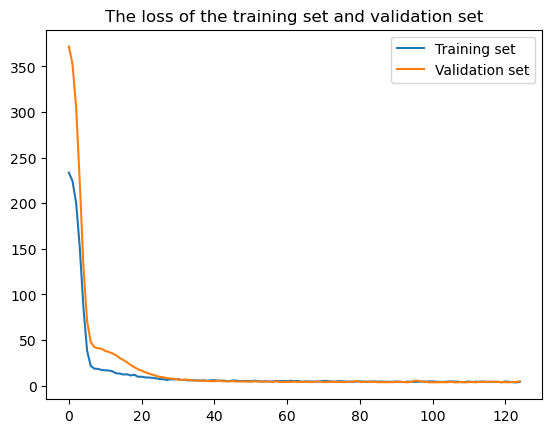

In [298]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import (Input, Dense)
# Define architecture here

model1b = keras.Sequential()

# Add layers to the model
model1b.add(Input(shape=(X_train_lags_scaled.shape[1],)))
model1b.add(Dense(256, activation = 'relu'))
model1b.add(Dense(256, activation = 'tanh'))
#model1b.add(Dense(256, activation = 'relu'))
#model1b.add(Dense(256, activation = 'relu'))
model1b.add(Dense(128, activation = 'relu')) #hidden layer 1
model1b.add(Dense(64, activation = 'tanh')) #hidden layer 2
model1b.add(Dense(32, activation = 'relu'))
model1b.add(Dense(256, activation = 'relu'))
model1b.add(keras.layers.Dropout(0.5))
model1b.add(Dense(1, activation = 'linear'))

model1b.summary()

# Compile model here
model1b.compile(loss = 'mse', optimizer = keras.optimizers.Adam(learning_rate = 1e-4))

# Fit model here
history = model1b.fit(
    x = X_train_lags_scaled,
    y = y_train,
    epochs = 150,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [EarlyStopping(patience = 15, monitor='val_loss')],
    shuffle = False
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("The loss of the training set and validation set")
plt.legend(["Training set","Validation set"])
plt.show()

Epoch 1/100
32/32 [==============================] - 2s 3ms/step - loss: 256.1291
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 194.9079
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 47.1021
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 19.5115
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 15.2843
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 12.4749
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 9.8799
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 7.5914
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 5.4462
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 3.9830
Epoch 11/100
32/32 [==============================] - 0s 3ms/step - loss: 3.0755
Epoch 12/100
32/32 [==============================] - 0s 3ms/step - loss: 2.8314
Epoch 13/100
32/32 [=========

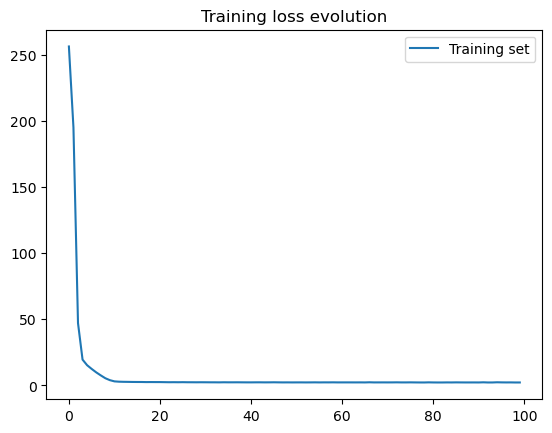

8/8 [==============================] - 0s 904us/step
RMSE: 1.3939967861203582 R2: 0.8294406169999535


In [299]:
#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Assume X_train, y_train, X_test, y_test are already defined

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_lags)
X_test_scaled = scaler.transform(X_test_lags)

# Reshape input to be [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


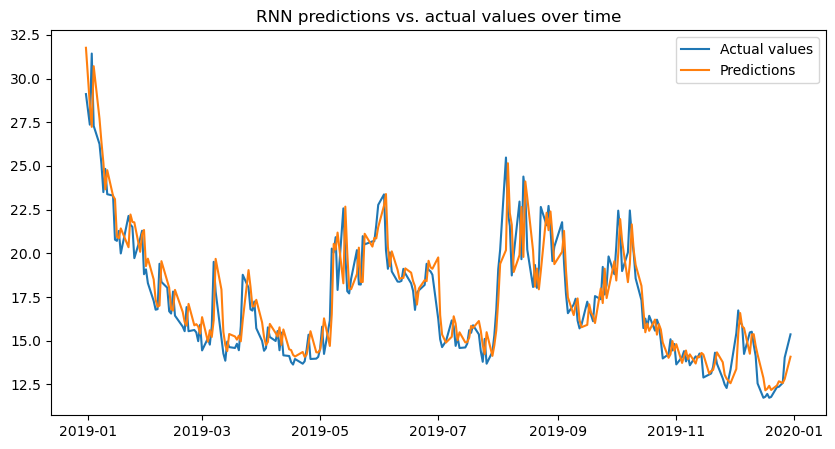

In [300]:
#plot prediction vs actual over time:
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred)
plt.title('RNN predictions vs. actual values over time')
plt.legend(['Actual values', 'Predictions'])
plt.show()

Epoch 1/200
16/16 [==============================] - 4s 13ms/step - loss: 260.2053
Epoch 2/200
16/16 [==============================] - 0s 12ms/step - loss: 221.9921
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 93.1727
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 36.5858
Epoch 5/200
16/16 [==============================] - 0s 13ms/step - loss: 37.2948
Epoch 6/200
16/16 [==============================] - 0s 12ms/step - loss: 34.9641
Epoch 7/200
16/16 [==============================] - 0s 14ms/step - loss: 33.1386
Epoch 8/200
16/16 [==============================] - 0s 11ms/step - loss: 29.7268
Epoch 9/200
16/16 [==============================] - 0s 15ms/step - loss: 32.7174
Epoch 10/200
16/16 [==============================] - 0s 11ms/step - loss: 32.4798
Epoch 11/200
16/16 [==============================] - 0s 13ms/step - loss: 32.1925
Epoch 12/200
16/16 [==============================] - 0s 11ms/step - loss: 29.5459
Epoch 13/20

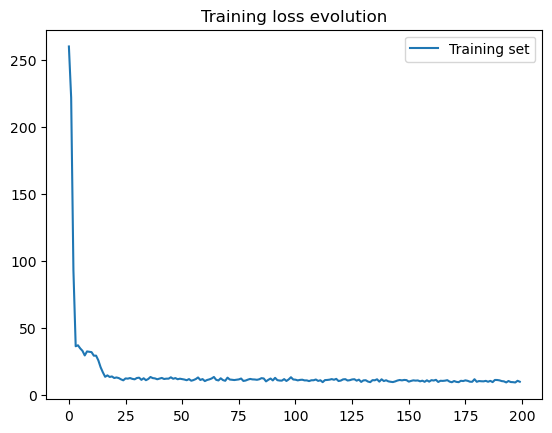

8/8 [==============================] - 1s 4ms/step
RMSE: 1.3863200524654502 R2: 0.8313139838641308


In [351]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assume X_train, y_train, X_test, y_test are already defined

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_lags)
X_test_scaled = scaler.transform(X_test_lags)

# Reshape input to be [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences = True))
model.add(LSTM(126, return_sequences = False))
model.add(Dense(64, activation='tanh'))
#model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=200, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


RMSE: 1.3863200524654502 R2: 0.8313139838641308: suuper close to the garch!! 
Try to improve more:

Epoch 1/150
16/16 [==============================] - 7s 14ms/step - loss: 259.7173
Epoch 2/150
16/16 [==============================] - 0s 14ms/step - loss: 181.7884
Epoch 3/150
16/16 [==============================] - 0s 14ms/step - loss: 43.7559
Epoch 4/150
16/16 [==============================] - 0s 14ms/step - loss: 34.4229
Epoch 5/150
16/16 [==============================] - 0s 14ms/step - loss: 34.0345
Epoch 6/150
16/16 [==============================] - 0s 14ms/step - loss: 31.5711
Epoch 7/150
16/16 [==============================] - 0s 14ms/step - loss: 28.2227
Epoch 8/150
16/16 [==============================] - 0s 14ms/step - loss: 25.5860
Epoch 9/150
16/16 [==============================] - 0s 14ms/step - loss: 20.6951
Epoch 10/150
16/16 [==============================] - 0s 15ms/step - loss: 19.1319
Epoch 11/150
16/16 [==============================] - 0s 14ms/step - loss: 14.7027
Epoch 12/150
16/16 [==============================] - 0s 14ms/step - loss: 14.0190
Epoch 13/15

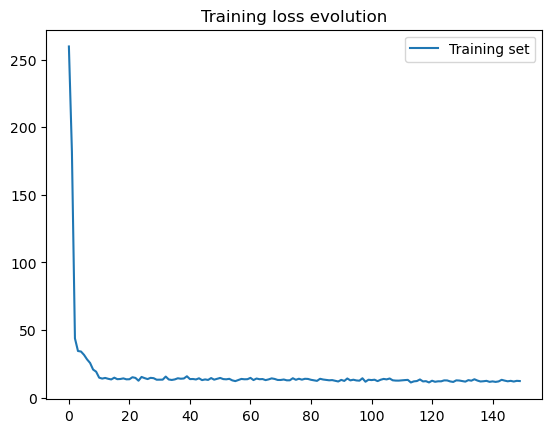

8/8 [==============================] - 1s 4ms/step
RMSE: 1.3691532609687478 R2: 0.8354657933127245


In [364]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam

# Assume X_train, y_train, X_test, y_test are already defined

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_lags)
X_test_scaled = scaler.transform(X_test_lags)

# Reshape input to be [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences = True))
model.add(SimpleRNN(125, return_sequences = True))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


Epoch 1/150
16/16 [==============================] - 10s 18ms/step - loss: 261.9604
Epoch 2/150
16/16 [==============================] - 0s 19ms/step - loss: 220.6189
Epoch 3/150
16/16 [==============================] - 0s 18ms/step - loss: 82.1756
Epoch 4/150
16/16 [==============================] - 0s 19ms/step - loss: 43.5479
Epoch 5/150
16/16 [==============================] - 0s 19ms/step - loss: 40.6388
Epoch 6/150
16/16 [==============================] - 0s 21ms/step - loss: 39.4518
Epoch 7/150
16/16 [==============================] - 0s 21ms/step - loss: 38.7614
Epoch 8/150
16/16 [==============================] - 0s 20ms/step - loss: 36.8279
Epoch 9/150
16/16 [==============================] - 0s 21ms/step - loss: 39.9066
Epoch 10/150
16/16 [==============================] - 0s 20ms/step - loss: 37.1225
Epoch 11/150
16/16 [==============================] - 0s 19ms/step - loss: 34.6171
Epoch 12/150
16/16 [==============================] - 0s 20ms/step - loss: 39.2439
Epoch 13/1

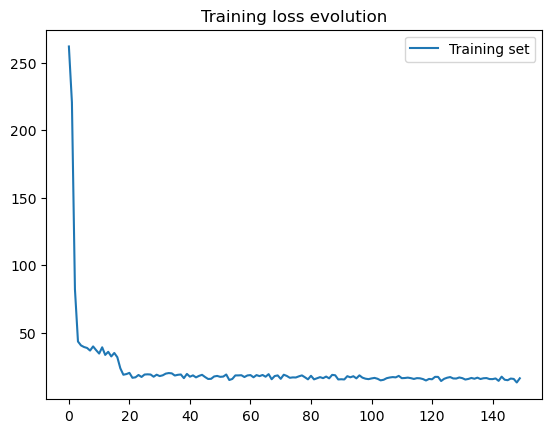

8/8 [==============================] - 1s 3ms/step
RMSE: 1.5324601310736532 R2: 0.7938751082779882


In [368]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam

# Assume X_train, y_train, X_test, y_test are already defined

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_lags)
X_test_scaled = scaler.transform(X_test_lags)

# Reshape input to be [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences = True))
model.add(SimpleRNN(125, return_sequences = True))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


Lower RMSE than GARCH! But also lower R2... idk why

Same but rolling window forecasting:
- tried it and it made the results worse and was way too computationally heavy so i think not relevant.

Try:
- Using the scaled data on the other models and see if that changes their results to make it comparable

GARCH:

In [302]:
#choose lags based on BIC:
import numpy as np
import pandas as pd
from arch import arch_model


# Possible values for p and q
p_values = range(1, 4)  # You can adjust these ranges based on what you consider reasonable
q_values = range(1, 4)

# Initialize variables to store the best model settings
best_bic = np.inf
best_p = None
best_q = None
best_model = None

# Grid search for the best BIC
for p in p_values:
    for q in q_values:
        model = arch_model(y_train, vol='Garch', p=p, q=q)
        fit = model.fit(disp='off')
        
        # Check if we found a new best BIC
        if fit.bic < best_bic:
            best_bic = fit.bic
            best_p = p
            best_q = q
            best_model = fit

# Output the best model's parameters and BIC
print(f"Best BIC: {best_bic} found for p={best_p} and q={best_q}")
print(best_model.summary())


Best BIC: 4750.298504449025 found for p=1 and q=1
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2361.33
Distribution:                  Normal   AIC:                           4730.65
Method:            Maximum Likelihood   BIC:                           4750.30
                                        No. Observations:                 1004
Date:                Mon, Apr 15 2024   Df Residuals:                     1003
Time:                        11:57:16   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            13.490

In [303]:
#look at adf test for the original series and the returns to see if maybe original was stationary:

from statsmodels.tsa.stattools import adfuller

adfuller(merged_df['Volatility'])

(-4.556826781786629,
 0.00015502472451948518,
 6,
 1250,
 {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776},
 4456.51981101696)

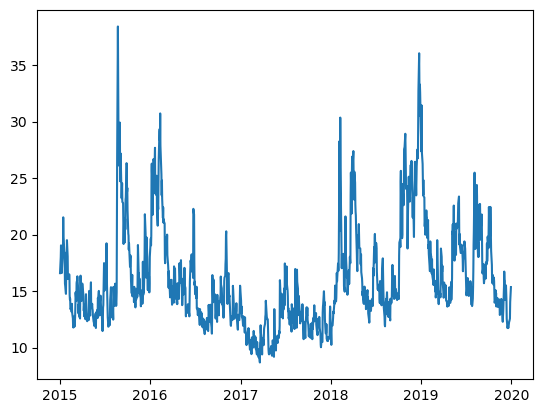

In [304]:
plt.plot(merged_df['Date'],merged_df['Volatility'])

In [305]:
merged_df['Volatility'].mean()

15.95466984884646

In [306]:
adfuller(y_train)

(-3.3960948380960514,
 0.01109272087826792,
 5,
 998,
 {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573},
 3579.774168781866)

In [307]:
adfuller(y_test)

(-4.343631726749592,
 0.0003729656690747745,
 0,
 251,
 {'1%': -3.4566744514553016,
  '5%': -2.8731248767783426,
  '10%': -2.5729436702592023},
 802.5970697112823)

c:\Users\ingam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ingam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ingam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\ingam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ingam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ingam\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\ingam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsuppo

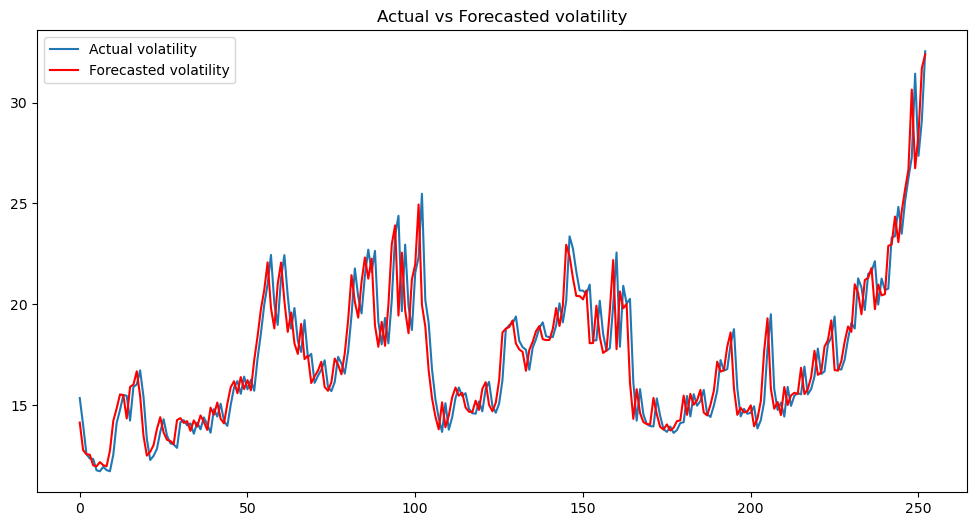

In [308]:
from statsmodels.tsa.arima.model import ARIMA
volatility = merged_df['Volatility']
# Set the training window size
train_size = len(y_train)

# Set forecast horizon
forecast_horizon = 1

# Initialize lists to store forecasts
mean_forecasts = []
variance_forecasts = []

for i in range(train_size, len(volatility)):
    # Training data for current window
    train_data = volatility[:i]

    # ARIMA model for mean
    arima_model = ARIMA(train_data, order=(1,0,0)) #data has ar(1) structure if we look at acf and pacf
    arima_result = arima_model.fit()
    mean_forecast = arima_result.forecast(steps=forecast_horizon)

    # GARCH model for variance
    garch_model = arch_model(train_data, vol='Garch', p=1, q=1)
    garch_result = garch_model.fit(disp='off')
    variance_forecast = garch_result.forecast(horizon=forecast_horizon).variance.values[-1, :][0]

    # Store forecasts
    mean_forecasts.append(mean_forecast)
    variance_forecasts.append(variance_forecast)

# Convert forecasts to Series for further analysis or plotting
mean_forecast_series = pd.Series(mean_forecasts, index=volatility.index[train_size:])
variance_forecast_series = pd.Series(variance_forecasts, index=volatility.index[train_size:])

# Plot the actual returns vs forecasted returns
plt.figure(figsize=(12, 6))
plt.plot(volatility.index[train_size:], volatility[train_size:], label='Actual volatility')
plt.plot(mean_forecast_series.index, mean_forecast_series, color='red', label='Forecasted volatility')
plt.legend()
plt.title('Actual vs Forecasted volatility')
plt.show()

In [326]:
np.sqrt(mean_squared_error(volatility[train_size:], mean_forecasts))

1.3763253732072933

In [327]:
r2_score(volatility[train_size:], mean_forecasts)

0.8455265362578446

We see that this result is the best out of all so far... better than all the machine learning methods.


Try boosting stuff with standardized data and see if it makes a difference:

In [337]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 100, 'max_depth': 10}, 
    "AdaBoost": {'n_estimators': 50, 'learning_rate': 0.1},
    "Gradient Boosting": {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1}
}

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Window size
window_size = 252  # days -> 252 is the number of days in the data / 5 (so ~the number of days per year of the data)

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start rolling window forecast
    for i in range(len(X_test_lags_scaled)):  # assuming X_test_lags is the test set features
        # Define the start point for the training window
        start_point = max(0, len(X_train_lags_scaled) + i - window_size)
        end_point = len(X_train_lags_scaled) + i

        # Train model on current window data
        X_train_rolling = pd.concat([pd.DataFrame(X_train_lags_scaled), pd.DataFrame(X_test_lags_scaled).iloc[:i]]).iloc[start_point:end_point]
        y_train_rolling = pd.concat([y_train, y_test.iloc[:i]]).iloc[start_point:end_point]
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_rolling, y_train_rolling)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(pd.DataFrame(X_test_lags_scaled).iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest


Model:   AdaBoost
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.4943448759975406, 'R2': 0.8040010481810622}, 'AdaBoost': {'RMSE': 1.591110214315957, 'R2': 0.7777956284490983}, 'Gradient Boosting': {'RMSE': 1.5622071414267715, 'R2': 0.7857951455394006}}


Want to try to experiment with more hyperparameters for the boosting algorithms:

In [377]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance2 = {}
model_predictions2 = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train_lags, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test_lags)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions2[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance2)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}


RandomForestRegressor(max_depth=4, n_estimators=75, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.10222222222222221, max_depth=2,
                          n_estimators=84, random_state=42)
{'Random Forest': {'RMSE': 1.4843645845477091, 'R2': 0.8066103447310062, 'Best Params': {'n_estimators': 75, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.6153301809749392, 'R2': 0.7709793270827571, 'Best Params': {'n_estimators': 84, 'max_depth': 2, 'learning_rate': 0.10222222222222221}}}


what to compare to:
- 'Random Forest': 
    - 'RMSE': 1.597527401334584, 
    - 'R2': 0.7759996466435833, 
    - 'Best Params': {'n_estimators': 100, 'max_depth': 10}
- 'Gradient Boosting': 
    - 'RMSE': 1.7759175737543775, 
    - 'R2': 0.7231798618691797, 
    - 'Best Params': {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}

In [378]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 75, 'max_depth': 4}, 
    "Gradient Boosting": {'n_estimators': 84, 'max_depth': 2, 'learning_rate': 0.10222222222222221}
}

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Window size
window_size = 252  # days -> 252 is the number of days in the data / 5 (so ~the number of days per year of the data)

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start rolling window forecast
    for i in range(len(X_test_lags_scaled)):  # assuming X_test_lags is the test set features
        # Define the start point for the training window
        start_point = max(0, len(X_train_lags_scaled) + i - window_size)
        end_point = len(X_train_lags_scaled) + i

        # Train model on current window data
        X_train_rolling = pd.concat([pd.DataFrame(X_train_lags_scaled), pd.DataFrame(X_test_lags_scaled).iloc[:i]]).iloc[start_point:end_point]
        y_train_rolling = pd.concat([y_train, y_test.iloc[:i]]).iloc[start_point:end_point]
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_rolling, y_train_rolling)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(pd.DataFrame(X_test_lags_scaled).iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest


Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.4602052274425816, 'R2': 0.8128542930522512}, 'Gradient Boosting': {'RMSE': 1.545187979611867, 'R2': 0.7904369486829325}}


In [383]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 75, 'max_depth': 4}, 
    "Gradient Boosting": {'n_estimators': 76, 'max_depth': 1, 'learning_rate': 0.10857142857142857}
}

# Initialize dictionaries to store results
model_performance3 = {}
model_predictions2 = {}

# Window size
window_size = 252  # days -> 252 is the number of days in the data / 5 (so ~the number of days per year of the data)

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start rolling window forecast
    for i in range(len(X_test_lags_scaled)):  # assuming X_test_lags is the test set features
        # Define the start point for the training window
        start_point = max(0, len(X_train_lags_scaled) + i - window_size)
        end_point = len(X_train_lags_scaled) + i

        # Train model on current window data
        X_train_rolling = pd.concat([pd.DataFrame(X_train_lags_scaled), pd.DataFrame(X_test_lags_scaled).iloc[:i]]).iloc[start_point:end_point]
        y_train_rolling = pd.concat([y_train, y_test.iloc[:i]]).iloc[start_point:end_point]
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_rolling, y_train_rolling)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(pd.DataFrame(X_test_lags_scaled).iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance3[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance3)


Model:   Random Forest
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.4602052274425816, 'R2': 0.8128542930522512}, 'Gradient Boosting': {'RMSE': 1.535907370701606, 'R2': 0.7929467172832808}}


In [384]:
display(model_performance3)
display(model_performance2)


{'Random Forest': {'RMSE': 1.4602052274425816, 'R2': 0.8128542930522512},
 'Gradient Boosting': {'RMSE': 1.535907370701606, 'R2': 0.7929467172832808}}

{'Random Forest': {'RMSE': 1.4602052274425816, 'R2': 0.8128542930522512},
 'Gradient Boosting': {'RMSE': 1.545187979611867, 'R2': 0.7904369486829325}}

Try: Running models without the monthly data stuff (interest rates inflation etc.)
-> see if that stuff is messing with the result